In [39]:
import os
import csv
from contextlib import contextmanager
from testsuite import iterate_suites
from collections import defaultdict, namedtuple
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('font', size=9)
plt.rc('axes', labelsize=9)
plt.rc('ytick', labelsize=9)
plt.rc('xtick', labelsize=9)
plt.rc('legend', fontsize=9)
plt.rc('figure', titlesize=9)
plt.rcParams["font.family"] = "sans-serif"

def load(proj_name, bug_id = None, ratio = None):
    data = []
    target_dir = os.path.join("cov", proj_name)
    if bug_id is not None:
        target_dir = os.path.join(target_dir, bug_id)

    for root, dirs, files in os.walk(target_dir):
        if bug_id is None:
            bug_id = os.path.split(root)[1]

        for filename in files:
            if not filename.endswith(".csv"):
                continue
            if os.path.split(root)[1].startswith("."):
                continue

            ratio_type = filename.split(".")[0]
            try:
                ratio_type = float(ratio_type) / 1000.0
            except ValueError:
                pass                
                
            if ratio is not None and ratio != ratio_type:
                continue

            with open(os.path.join(root, filename), "r") as fh:
                reader = csv.reader(fh)
                for row in reader:
                    row[2] = float(row[2])
                    row[3] = float(row[3])
                    row[4] = float(row[4])
                    row[5] = float(row[5])

                    data.append(row)

    if len(data) == 0:
        return None

    data = pd.DataFrame(data)
    data.columns = ["name", "bug_id", "ratio", "cls_level", "method_level", "stmt_level", "is_bug"]
    return data.loc[data["cls_level"].notnull() & data["method_level"].notnull() & data["stmt_level"].notnull(), :]

ALL_PROJ = ["Chart", "Time", "Closure", "Lang", "Math"]

In [14]:
from killmap import Killmap
from patch import load_changes

def read_lines(p):
    with open(p, "r") as fh:
        for line in fh:
            yield line


def _load_mutants(suite):
    l2m = defaultdict(set)
    l2l = defaultdict(lambda: defaultdict(set))
    cnt = 0

    try:
        for line in Killmap.iterate_mutants(suite):
            cnt += 1
            arguments = line.split(":")
            mid = int(arguments[0]) - 1
            method_name = arguments[4]
            line_no = int(arguments[5])

            line_key = method_name.split("@")[0]

            l2m[method_name].add(mid)
            l2l[line_key][line_no].add(mid)


        return l2m, l2l, cnt
    except:
        return None, None, None


empties = {
    "Math-34f-dev": {"org.apache.commons.math3.genetics.ListPopulation@iterator()"},
    "Math-58f-dev": {"org.apache.commons.math.optimization.fitting.GaussianFitter@fit()"},
    "Math-70f-dev": {"org.apache.commons.math.analysis.solvers.BisectionSolver@solve(org.apache.commons.math.analysis.UnivariateRealFunction,double,double,double)"},
    "Math-75f-dev": {"org.apache.commons.math.stat.Frequency@getPct(java.lang.Object)"},
    "Math-104f-dev": {"org.apache.commons.math.special.Gamma@regularizedGammaP(double,double)", "org.apache.commons.math.special.Gamma@regularizedGammaQ(double,double)"},
    "Lang-25f-dev": {"org.apache.commons.lang3.text.translate.EntityArrays@ISO8859_1_ESCAPE()", "org.apache.commons.lang3.text.translate.EntityArrays@ISO8859_1_UNESCAPE()"},
    "Lang-29f-dev": {"org.apache.commons.lang3.SystemUtils@toJavaVersionFloat(java.lang.String)"},
    "Lang-34f-dev": {"org.apache.commons.lang3.builder.ToStringStyle@getRegistry()"},
    "Lang-57f-dev": {"org.apache.commons.lang.LocaleUtils@isAvailableLocale(java.util.Locale)"},
    "Lang-64f-dev": {"org.apache.commons.lang.enums.ValuedEnum@getValueInOtherClassLoader(java.lang.Object)"},
    "Chart-8f-dev": {"org.jfree.data.time.Week@<init>(java.util.Date,java.util.TimeZone)"},
    "Closure-8f-dev": {"com.google.javascript.jscomp.CollapseVariableDeclarations@isNamedParameter(com.google.javascript.jscomp.Scope.Var)"},
    "Closure-16f-dev": {"com.google.javascript.jscomp.ScopedAliases$AliasedTypeNode@<init>(com.google.javascript.jscomp.ScopedAliases,com.google.javascript.rhino.Node,com.google.javascript.rhino.Node,java.lang.String)"},
    "Closure-26f-dev": {"com.google.javascript.jscomp.ProcessCommonJSModules$ProcessCommonJsModulesCallback@<init>(com.google.javascript.jscomp.ProcessCommonJSModules)"},
    "Closure-27f-dev": {"com.google.javascript.rhino.IR@blockUnchecked(com.google.javascript.rhino.Node)"},
    "Closure-146f-dev": {"com.google.javascript.rhino.jstype.JSType@getTypesUnderInequality(com.google.javascript.rhino.jstype.JSType)"}
}

IGNORED = {
    "Math": set([12, 77, 34, 58, 70, 75]),
    "Time": set([11]),
    "Lang": set([23, 29, 32, 57]),
    "Closure": set([28, 46, 112, 135, 137, 148, 158, 162, 163, 175]),
    "Chart": set([8])
}

method_empty = set()
stmt_empty = set()
def compute_mutants(suites):
    global empties, method_empty, stmt_empty
    suite = suites[0]
    line_changes, method_changes = load_changes(suite.proj_name, suite.bug_id)
    if line_changes is None or method_changes is None:
        return None
    
    mutants_by_methods, mutants_by_line, mutants_size = _load_mutants(suite)
    method_level_mutants = set()
    line_level_mutants = set()

    for method_name in method_changes:
        selected = mutants_by_methods.get(method_name)
        if selected is None:
            if str(suite) not in empties or method_name not in empties[str(suite)]:
                print("Should confirm that", method_name, "has no mutants")
                return None
        else:
            method_level_mutants |= selected
            
    if len(method_level_mutants) == 0:
        method_empty.add(str(suite))
        return None  
            
    for key, lines in line_changes.items():
        l = mutants_by_line.get(key)
        if l is None:
            continue
            
        for line_no in lines:
            result = l.get(line_no)
            if result is not None:
                line_level_mutants |= result
    
    if len(line_level_mutants) == 0:
        stmt_empty.add(str(suite))
        return None
    
    fails = set()
    for suite in suites:
        if suite.trigger_tests is not None:
            fails |= suite.trigger_tests
        
    if len(fails) == 0:
        print("No triggering tests found----------------------.")
        return None

    relevant = set()
    for suite in suites:
        km = Killmap(suite)
        for row in km.iterate_killmap():
            test_name = row[0]
            try:
                fails.remove(test_name)
            except KeyError:
                continue
                
            for idx in range(1, len(row)):
                if row[idx] in {"EXC", "FAIL"}:
                    relevant.add(idx - 1)
    
    return mutants_size - len(relevant), mutants_size, len(method_level_mutants - relevant), len(method_level_mutants), len(line_level_mutants - relevant), len(line_level_mutants),


cls_level_change = set()
size_exc = set()
total = 0
timeout = set()
tbl = {
    "class": [],
    "cls_total": [],
    "method": [],
    "method_total": [],
    "stmt": [],
    "stmt_total": []
}
total = defaultdict(lambda: 0)
t = 0
for proj_name in ALL_PROJ:
    for suites in iterate_suites(proj_name):
        t += 1
        dev = suites[0]
        
        if any(x.changes is None for x in suites):
            cls_level_change.add(str(dev))
            continue

        suites = list(filter(lambda x: x.available(), suites))
        if len(suites) == 0:
            continue

        proj_name = dev.proj_name
        bug_id = dev.bug_id


        if int(bug_id[:-1]) in IGNORED[proj_name]:
            continue

        is_available = True
        failed = 0
        total_size = 0
        for suite in suites:
            km = Killmap(suite)
            snapshot = km.snapshot()
            if len(snapshot.get("unknown", [])) > 0:
                is_available = False
                break
            elif len(snapshot.get("timeout", [])) > 0:
                is_available = False
                break

            size = len(snapshot.get("covered", []))
            if size > 0:
                total_size += size
                if suite.trigger_tests is not None:
                    failed += len(suite.trigger_tests)

        if not is_available or failed == 0 or total_size < 532:
            if total_size < 532:
                size_exc.add(str(dev))
            else:
                timeout.add(str(dev))

            continue

        result = compute_mutants(suites)
        if result is None:
            continue
        else:
            c, ct, m, mt, s, st = result
            tbl["class"].append(c)
            tbl["cls_total"].append(ct)
            tbl["method"].append(m)
            tbl["method_total"].append(mt)
            tbl["stmt"].append(s)
            tbl["stmt_total"].append(st)
            total[proj_name] += 1

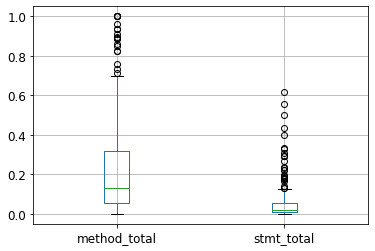

In [15]:
df = pd.DataFrame(tbl)
t = "cls_total"
m = "method_total"
s = "stmt_total"
x = df.loc[:, [t, m, s]]
x[m] = x.apply(lambda r: r[m] / r[t], axis=1)
x[s] = x.apply(lambda r: r[s] / r[t], axis=1)
x.drop(columns=[t]).boxplot()

0.088098582129481
0.009709653092006033


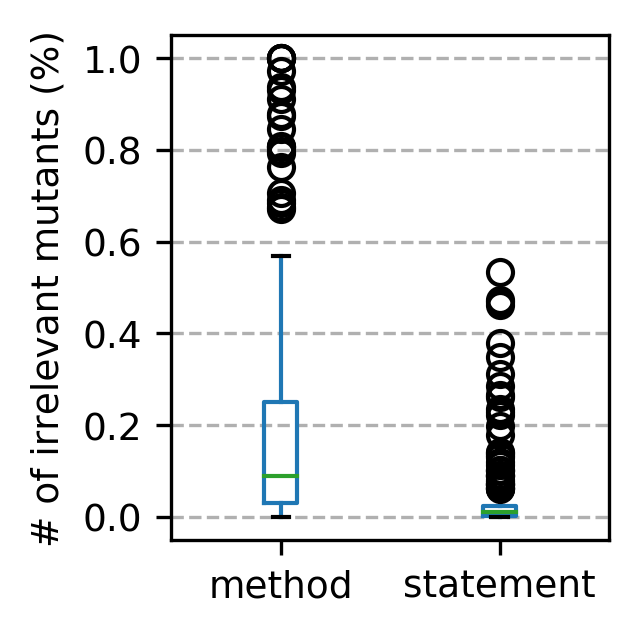

In [42]:
df = pd.DataFrame(tbl)
df = df.loc[df["class"] > 0,:]
df["method"] = df.apply(lambda r: r["method"] / r["class"], axis=1)
df["stmt"] = df.apply(lambda r: r["stmt"] / r["class"], axis=1)
print(np.median(df["method"]))
print(np.median(df["stmt"]))

fig = plt.figure(figsize=(2.2, 2.2,), dpi=300)
axs = fig.gca()
df = df.loc[:, ["method", "stmt"]]
df.columns = ["method", "statement"]
df.boxplot(ax=axs)

axs.set_ylabel("# of irrelevant mutants (%)")

axs.get_xaxis().grid(False)
axs.get_yaxis().grid(True, linestyle='--')
plt.tight_layout()
plt.savefig('../seke/fig6.png', format='png', dpi=300)

In [18]:
import scipy.stats
import itertools
import numpy as np

def load_groupby_isbug(name):
    passing = None
    failing = None
    for ratio in ["max20"]:
        data = load(name, None, ratio)
        if data is None:
            return None, None
        
        g = data.groupby("is_bug").groups
        if passing is None:
            passing = data.loc[g["True"], :].reset_index(drop=True)
            failing = data.loc[g["False"], :].reset_index(drop=True)
        else:
            passing.append(data.loc[g["True"], :].reset_index(drop=True))
            failing.append(data.loc[g["False"], :].reset_index(drop=True))
            
    return passing, failing

dis = [pd.DataFrame() for _ in range(8)]
titles = ["class-level (passed)", "class-level (failed)", "method-level (passed)", "method-level (failed)", "statement-level (passed)", "statement-level (failed)", "size (passed)", "size (failed)"]
cls_passed, cls_failed, method_passed, method_failed, stmt_passed, stmt_failed, size_passed, size_failed = dis
for name in ALL_PROJ:
    failed, passed = load_groupby_isbug(name)
    if failed is None:
        continue

    cls_passed[name] = passed["cls_level"]
    cls_failed[name] = failed["cls_level"]
    method_passed[name] = passed["method_level"]
    method_failed[name] = failed["method_level"]
    stmt_passed[name] = passed["stmt_level"]
    stmt_failed[name] = failed["stmt_level"]
    size_passed[name] = passed["ratio"]
    size_failed[name] = failed["ratio"]

KeyboardInterrupt: 

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from collections import defaultdict
from testsuite import TestSuite
import numpy as np
import math
import scipy.stats as stats

result = None
pvalue = 0
pvalue_inst = 0
def predict(name):
    global result, pvalue, pvalue_inst
    result = {
        "cls_level": [],
        "method_level": [],
        "stmt_level": [],
        "ratio": [],
        "cls_levelXratio": [],
        "method_levelXratio": [],
        "stmt_levelXratio": []
    }
    for bug_id in os.listdir(os.path.join("cov", name)):
        data = load(name, bug_id, "max20")
        if data is None:
            continue

        truey = data["is_bug"]
        avg = sum(truey == "True") / len(truey)
        if avg == 1 or avg == 0:
            continue
            
        def loss(y):
            return log_loss(truey, y, normalize=False)

        XX = False
        intercept_loss = loss([[1 - avg, avg]] * len(truey))
        for t in [["cls_level"], ["method_level"], ["stmt_level"], ["ratio"], ["cls_level", "ratio"], ["method_level", "ratio"], ["stmt_level", "ratio"]]:
            X = data[t]
            clf = LogisticRegression(solver='lbfgs').fit(X, truey)
            denom = (2.0*(1.0+np.cosh(clf.decision_function(X))))
            denom = np.tile(denom,(X.shape[1],1)).T
            F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
            try:
                Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
            except Exception as e:
                print(name, bug_id, t)
                break

            sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
            z_scores = clf.coef_[0]/sigma_estimates # z-score for eaach model coefficient
            p_values = [stats.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
            
            if any(map(lambda x: x > 0.05, p_values)):
                pvalue += 1
                XX = True
                result["X".join(t)].append(None)
                continue
            
            clf_loss = loss(clf.predict_proba(X))
    
            rsq = 1 - clf_loss / intercept_loss
            result["X".join(t)].append(rsq)
        if XX:
            pvalue_inst += 1

for name in ALL_PROJ:
    predict(name)
print(pvalue)
print(pvalue_inst)

Chart 1f ['stmt_level']
Closure 95f ['method_level']
Closure 11f ['stmt_level']
228
140


NameError: name 'dis' is not defined

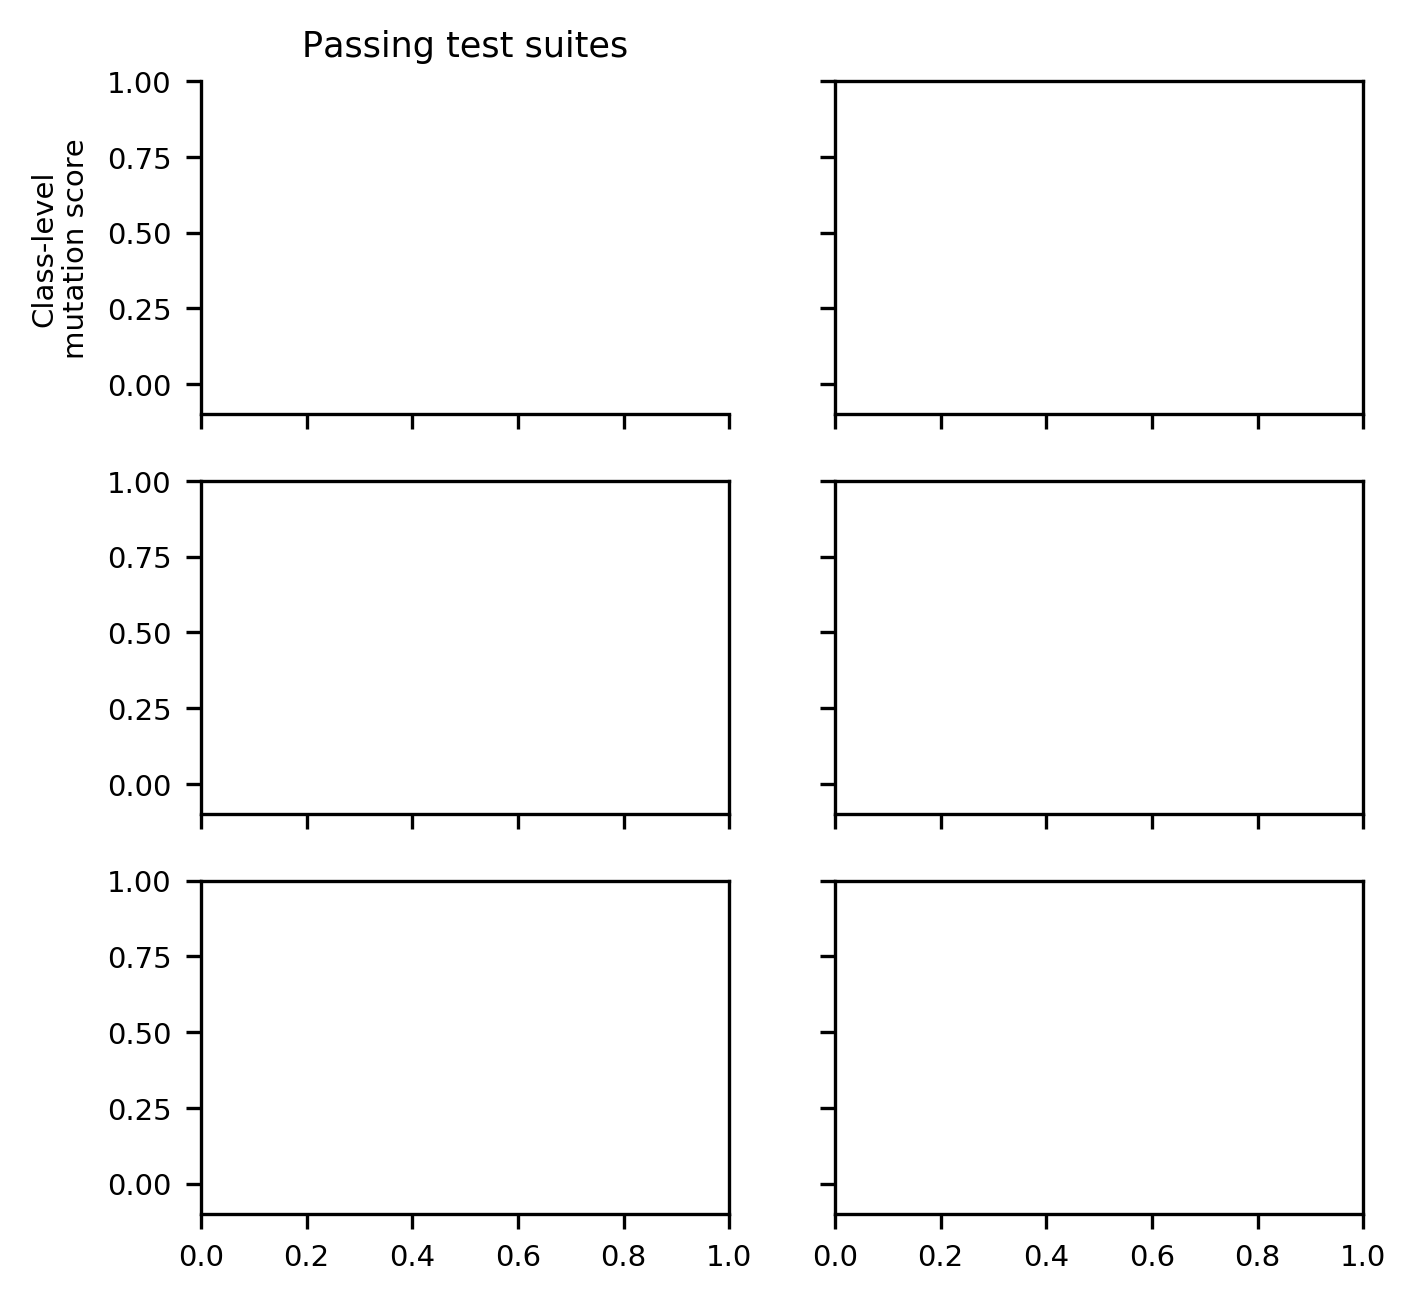

In [37]:
import matplotlib.pyplot as plt

tcol = 3
trow = 2
fig, axs = plt.subplots(tcol, trow, figsize=(5, 5,), sharex=True, sharey=True, dpi=300)
ylabels = ["Class-level", "Method-level", "Statement-level"]

for idx in range(6):
    row = int(idx / trow)
    col = int(idx % trow)
    axis = axs[row, col]
    axis.set_ylim(-0.1, 1)       
    if col == 0:       
        t = ylabels[row]
        axis.set_ylabel("{}\nmutation score".format(t))
        
    if row == 0:
        if col == 0:
            t = "Passing test suites"
        else:
            t = "Failing test suites"
            
        axis.set_title(t)
        
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)

    df = dis[idx]
    df.boxplot(ax=axis, showfliers=False)
    
    axis.get_xaxis().grid(False)
    axis.get_yaxis().grid(True, linestyle='--')
        

plt.tight_layout()
plt.savefig('../seke/fig1.png', format='png', dpi=300)
plt.show()

In [17]:
import scipy.stats

idx = 0
while idx < 2:
    c = dis[idx]
    m = dis[idx + 2]
    s = dis[idx + 4]
    
    for col in ["Chart", "Time", "Closure", "Lang", "Math"]:
        print(col)
        if idx == 0:
            print("passing")
        else:
            print("failing")
            
        print("CM:{}".format(scipy.stats.ks_2samp(c[col], m[col])))
        print("MS:{}".format(scipy.stats.ks_2samp(m[col], s[col])))
        print("CS:{}".format(scipy.stats.ks_2samp(c[col], s[col])))
    idx += 1

Chart
passing
CM:Ks_2sampResult(statistic=0.29599208856412934, pvalue=0.0)
MS:Ks_2sampResult(statistic=0.48514316585629386, pvalue=0.0)
CS:Ks_2sampResult(statistic=0.7736633427647904, pvalue=0.0)
Time
passing
CM:Ks_2sampResult(statistic=0.29081852228296207, pvalue=0.0)
MS:Ks_2sampResult(statistic=0.2551621203380674, pvalue=0.0)
CS:Ks_2sampResult(statistic=0.5122288456079628, pvalue=0.0)
Closure
passing
CM:Ks_2sampResult(statistic=0.1272331034987959, pvalue=0.0)
MS:Ks_2sampResult(statistic=0.4401651878508181, pvalue=0.0)
CS:Ks_2sampResult(statistic=0.5144264666831487, pvalue=0.0)
Lang
passing
CM:Ks_2sampResult(statistic=0.15858583083811773, pvalue=0.0)
MS:Ks_2sampResult(statistic=0.38648829308939736, pvalue=0.0)
CS:Ks_2sampResult(statistic=0.5193894276112774, pvalue=0.0)
Math
passing
CM:Ks_2sampResult(statistic=0.19823457773626707, pvalue=0.0)
MS:Ks_2sampResult(statistic=0.13782746843208893, pvalue=0.0)
CS:Ks_2sampResult(statistic=0.2591178382734024, pvalue=0.0)
Chart
failing
CM:Ks_2sam

In [18]:
np.median(cls_passed["Chart"])

0.15210843373493976

WilcoxonResult(statistic=702.0, pvalue=0.0009655212229772678)
WilcoxonResult(statistic=464.0, pvalue=3.099911677968629e-06)


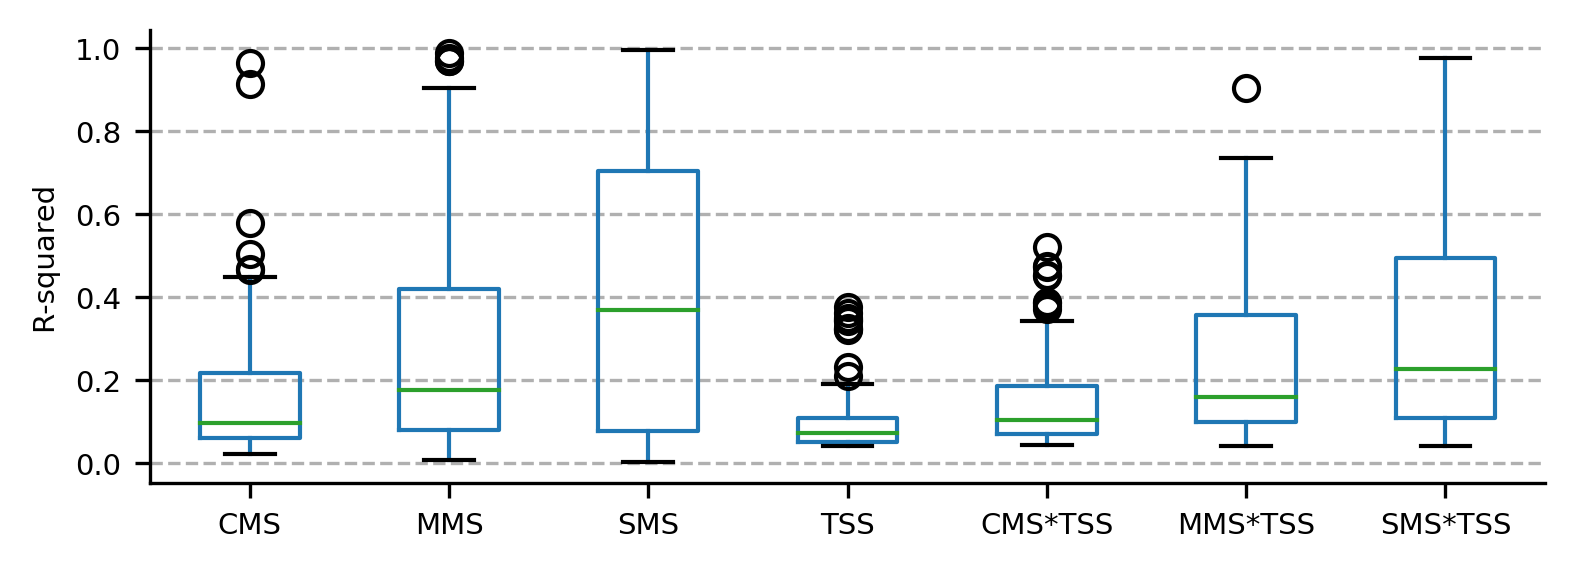

In [38]:
df = pd.DataFrame(result)
df.columns = ["CMS", "MMS", "SMS", "TSS", "CMS*TSS", "MMS*TSS", "SMS*TSS"]
fig = plt.figure(dpi=300, figsize=(6,2))
ax = df.boxplot(showfliers=True, ax = fig.gca())
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.get_xaxis().grid(False)
ax.get_yaxis().grid(True, linestyle='--')
ax.set_ylabel("R-squared".format(t))
ax.get_figure().savefig('../seke/fig2.png', format='png', dpi=300)

print(stats.wilcoxon(df["CMS"], df["MMS"]))
print(stats.wilcoxon(df["CMS"], df["SMS"]))

/home/mingwan/irrelevant/py/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mingwan/irrelevant/py/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mingwan/irrelevant/py/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mingwan/irrelevant/py/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/mingwan/irrelevant/py/lib/python3.6/site-packages/scipy/stats/stat

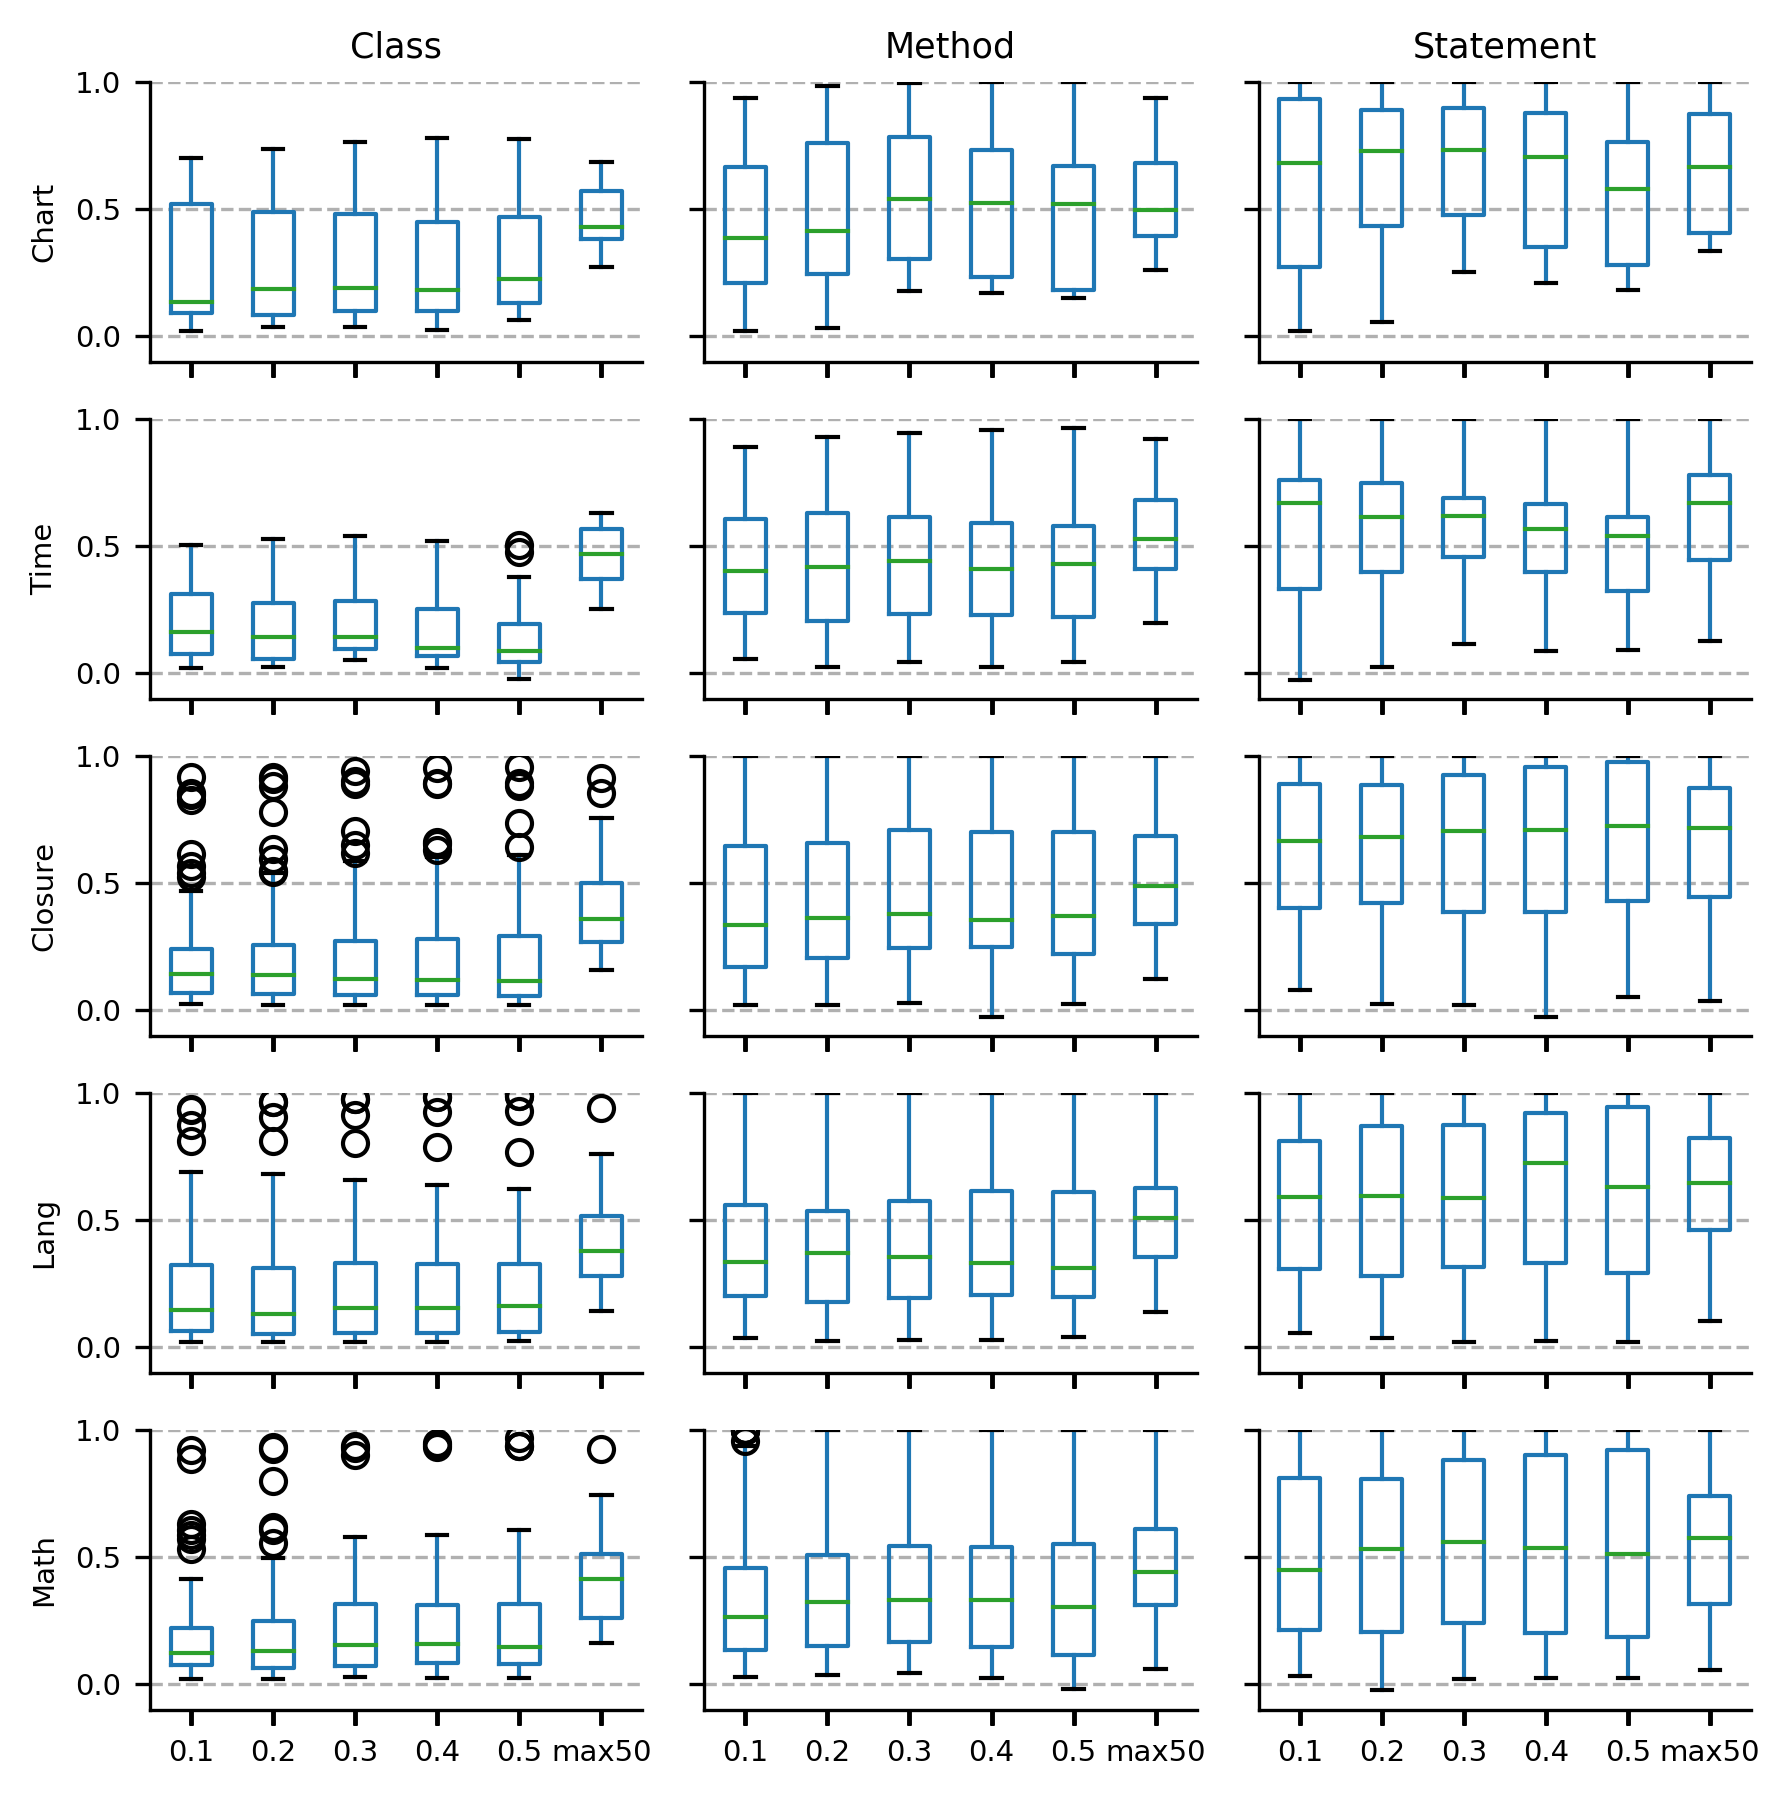

In [32]:
from collections import defaultdict

def load_by_size(name):
    keys = [0.1, 0.2, 0.3, 0.4, 0.5, "max50"]
    klass = {k: [] for k in keys}
    method = {k: [] for k in keys}
    stmt = {k: [] for k in keys}
    
    for bug_id in os.listdir(os.path.join("cov", name)):
        for ratio in keys:
            data = load(name, bug_id, ratio)
            if data is None:
                klass[ratio].append(None)
                method[ratio].append(None)
                stmt[ratio].append(None)
                continue
            
            bugs = data["is_bug"] == "True"
            if sum(bugs) == len(bugs):
                klass[ratio].append(None)
                method[ratio].append(None)
                stmt[ratio].append(None)
                continue
                
            def corr(to, key):
                cor, p = stats.pointbiserialr(bugs, data[key])
                to[ratio].append(cor if p < 0.05 else None)
                
            corr(klass, "cls_level")
            corr(method, "method_level")
            corr(stmt, "stmt_level")
            
    return pd.DataFrame(klass), pd.DataFrame(method), pd.DataFrame(stmt)

fig, axs = plt.subplots(5, 3, figsize=(6, 6,), dpi=300, sharex=True, sharey=True)
titles = ["Class", "Method", "Statement"]
for col_idx, name in enumerate(ALL_PROJ):
    klass, method, stmt = load_by_size(name)
    for idx, df in [(0, klass,), (1, method,), (2, stmt,)]:
        axis = axs[col_idx, idx]
        axis.set_ylim(-0.1, 1)
        axis.spines['right'].set_visible(False)
        axis.spines['top'].set_visible(False)
        df.boxplot(ax=axis, showfliers=True)
        axis.get_xaxis().grid(False)
        axis.get_yaxis().grid(True, linestyle='--')
        
        if idx == 0:
            axis.set_ylabel(name)
        if col_idx == 0:
            axis.set_title(titles[idx])
            
plt.tight_layout()
plt.savefig('../seke/fig3.png', format='png', dpi=300)
plt.show()

In [39]:
import scipy.stats
from collections import defaultdict, namedtuple
import numpy as np
import itertools
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def has_sole_label(df):
    bugs = df["is_bug"] == "True"
    return sum(bugs) == len(bugs)
    
    
def diffprop(obs):
    """
    `obs` must be a 2x2 numpy array.

    Returns:
    delta
        The difference in proportions
    ci
        The Wald 95% confidence interval for delta
    corrected_ci
        Yates continuity correction for the 95% confidence interval of delta.
    """
    n1, n2 = obs.sum(axis=1)
    prop1 = obs[0,0] / n1
    prop2 = obs[1,0] / n2
    delta = prop1 - prop2

    # Wald 95% confidence interval for delta
    se = np.sqrt(prop1*(1 - prop1)/n1 + prop2*(1 - prop2)/n2)
    return delta, 1.96*se + 0.5*(1/n1 + 1/n2)


def row(tbl):
    s = sum(tbl["is_bug"] == "True")
    return [s, len(tbl.index) - s]
        

pvalue = defaultdict(int)
def rq3(result, name, ratio):
    global pvalue
    
    for bug_id in os.listdir(os.path.join("cov", name)):
        data = load(name, bug_id, ratio)
        if data is None:
            continue

        bugs = data["is_bug"] == "True"
        if has_sole_label(data):
#                 print(name, bug_id)
            continue

        for t in ["cls_level", "method_level", "stmt_level"]:
            top10 = data.nlargest(int(len(data.index) / 10), t)
            others = data.drop(top10.index)

            tbl = np.array([row(top10), row(others)], int)
            try:
                chi, pval, dof, expected = stats.chi2_contingency(tbl)
                delta, se = diffprop(tbl)
                c = result[t + str(ratio)]
                c["values"].append(delta)
                c["errors"].append(se)
            except ValueError as e:
                pass

result = defaultdict(lambda: {"values": [], "errors": []})
for name, ratio in itertools.product(ALL_PROJ, range(25, 525, 25)):
    ratio /= 1000
    rq3(result, name, ratio)

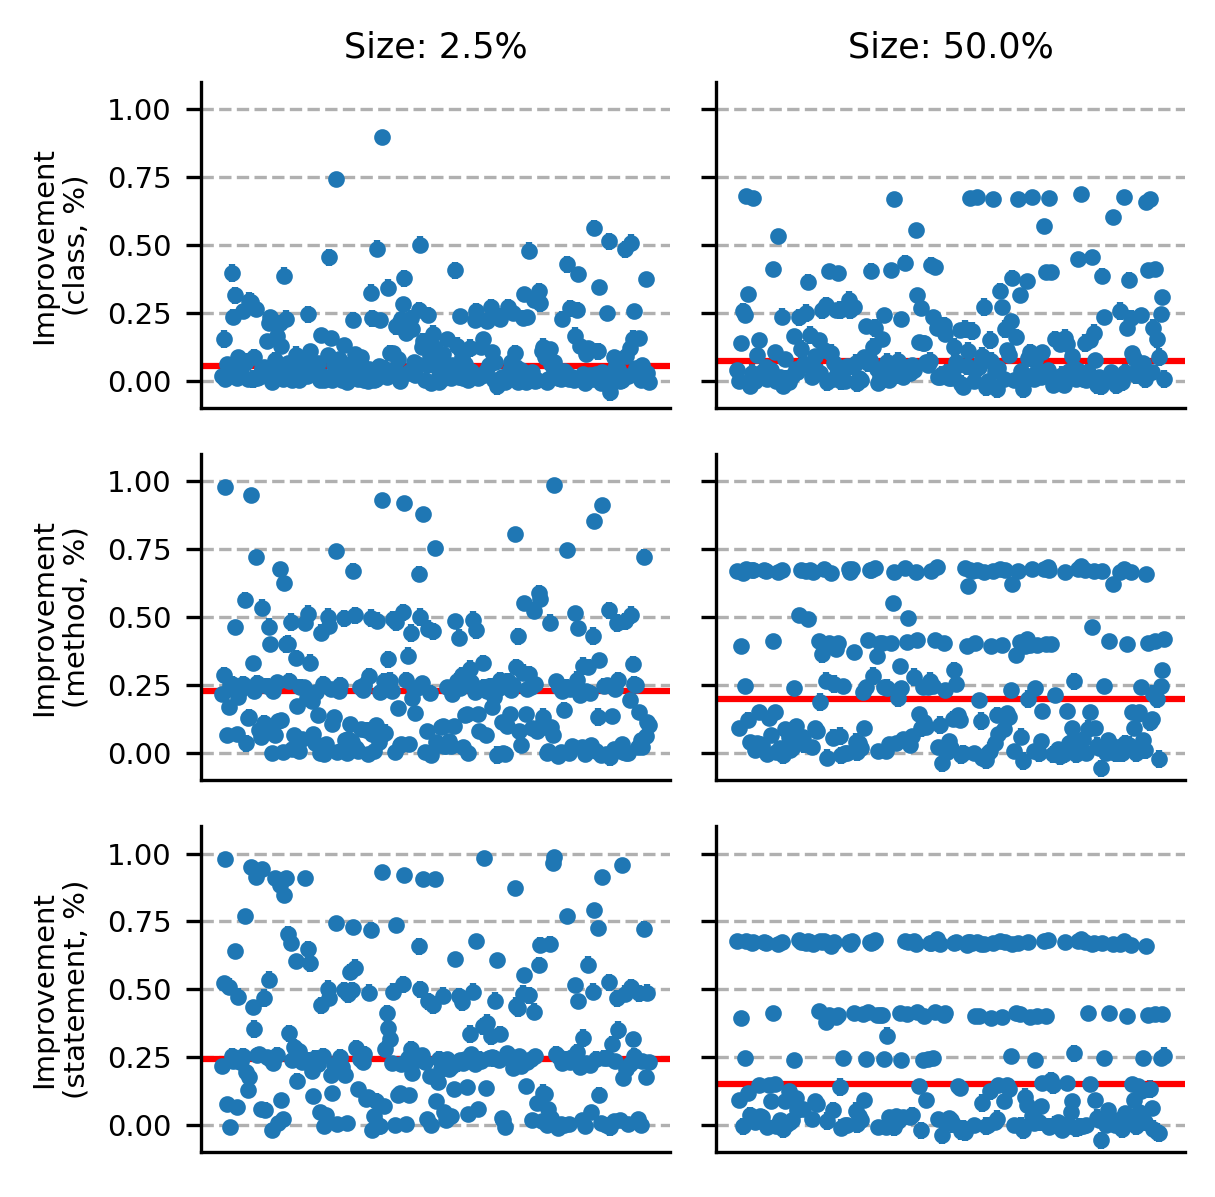

In [40]:
fig, axs = plt.subplots(3, 2, figsize=(4, 4), sharex=False, sharey=True, dpi=300)
levels = [("class", "cls_level",), ("method", "method_level",), ("statement", "stmt_level",)]
ratios = [0.025, 0.5]
for idx in range(6):
    col = int(idx / 2)
    row = int(idx % 2)
    
    ratio = ratios[row]
    name, t = levels[col]

    t = t + str(ratio)
    data = result[t]
    values = data["values"]
    median = np.median(values)
    errors = data["errors"]
    ax = axs[col, row]
    ax.errorbar(range(len(values)), values, yerr=errors, fmt='.', markersize=6)
    if col == 0:
        ax.set_title("TSS: {}%".format(str(ratio * 100)))
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().grid(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().grid(True, linestyle='--')
    ax.axhline(y=median, color='r', linestyle='-')

    ax.set_ylim(-0.1, 1.1)
    if row == 0:
        ax.set_ylabel("Improvement\n({}, %)".format(name))

plt.tight_layout()
plt.savefig('../seke/fig4.png', format='png', dpi=300)

In [ ]:
for ratio in range(25, 525, 25):
    data = result["cls_level" + str(ratio / 1000)]['values']
    c = np.median(data)
    
    data = result["method_level" + str(ratio / 1000)]['values']
    m = np.median(data)
    
    data = result["stmt_level" + str(ratio / 1000)]['values']
    s = np.median(data)
    
    if m - c < 0:
        print("MC", ratio)
    if s - m < 0:
        print("SM", ratio)

/home/mingwan/irrelevant/py/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


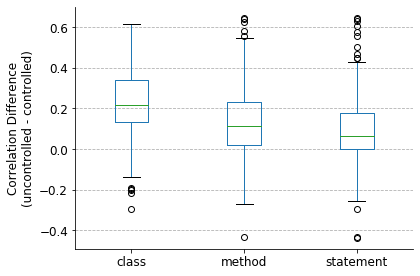

In [44]:
from collections import defaultdict
import matplotlib.pyplot as plt
import scipy.stats as stats
import itertools
import numpy as np
from patch import load_changes


def compute_ratio(name, bug_id, method_level_changes):
    method = 0
    total = 0
    p = os.path.join("mutations", name, bug_id, "mutants")
    if not os.path.exists(p):
        return None
    
    with open(p) as fh:
        for line in fh:
            total += 1
            arguments = line.split(":")
            method_name = arguments[4]
            if method_name in method_level_changes:
                method += 1
                
    return method / total


def size_vs_irrelevant():
    klass = []
    method = []
    stmt = []
    
    for name in ALL_PROJ:
        for bug_id in os.listdir(os.path.join("cov", name)):
            _, method_changes = load_changes(name, bug_id)
            if method_changes is None:
                continue

#             ratio = compute_ratio(name, bug_id, method_changes)
#             if ratio is None:
#                 continue

            data = load(name, bug_id, 0.3)
            if data is None:
                continue

            bugs = data["is_bug"] == "True"
            if sum(bugs) == len(bugs):
                continue

            kor = stats.pointbiserialr(bugs, data["cls_level"])[0]
            if np.isnan(kor):
                continue
            mor = stats.pointbiserialr(bugs, data["method_level"])[0]
            if np.isnan(mor):
                continue
            sor = stats.pointbiserialr(bugs, data["stmt_level"])[0]
            if np.isnan(sor):
                continue
            
            data = load(name, bug_id, "max50")
            if data is None:
                continue

            bugs = data["is_bug"] == "True"
            if sum(bugs) == len(bugs):
                continue
                
            x = stats.pointbiserialr(bugs, data["cls_level"])[0]
            if np.isnan(x):
                continue
            klass.append(x - kor)
            x = stats.pointbiserialr(bugs, data["method_level"])[0]
            if np.isnan(x):
                continue
            method.append(x - mor)
            x = stats.pointbiserialr(bugs, data["stmt_level"])[0]
            if np.isnan(x):
                continue
            stmt.append(x - sor)

    ax = pd.DataFrame({"class": klass, "method": method, "statement": stmt}).boxplot()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_xaxis().grid(False)
    ax.get_yaxis().grid(True, linestyle='--')
    ax.set_ylabel("Correlation Difference\n(uncontrolled - controlled)")
    plt.tight_layout()
    
size_vs_irrelevant()